# ElementOutput

AxiSEM3D can save the raw wavefield using the "elements" output type. This saves the Fourier and GLL coefficients at each (or a subset of) GLL point in each element of the mesh. Unlike the station output, this output takes considerably more disk storage, and has to be interpolated "manualy" by the user  at each point of interest. 

The ElementOutput class is designed to ease the handling of the elements output by providing tools for:
- Quickly accessing the raw data and its metadata.
- Providing a method for carying out the interpolation at any point inside spatio-temporal domain.
- Parsing the interpolated data into Obspy streams 

Furthermore, the class also has a method for producing simple animations of the wavefield through a selected region of the domain (working on speeding up this functionality using parallelization). 

In [11]:
from axikernels.core.handlers import element_output
import matplotlib.pyplot as plt
import numpy as np

To create an ElementOutput instance we only need the path to the elements output of the desired AxiSEM3D simulation.

In [12]:
data = element_output.ElementOutput(path_to_element_output='data/EXAMPLE_ELEMENT/output/elements')

The *.elements_groups_info* contains all the information about the output:

In [13]:
data.element_groups_info

{'mantle': {'elements': {'horizontal_range': [0, 3.141592653589793],
   'vertical_range': ['3400e3', '6371e3']},
  'inplane': {'edge_dimension': 'BOTH',
   'edge_position': '6371e3',
   'GLL_points_one_edge': [0, 2, 4]},
  'azimuthal': {'phi_list': [], 'lat_lon_list': [], 'na_space': 1},
  'wavefields': {'coordinate_frame': 'RTZ',
   'medium': 'SOLID',
   'channels': ['U', 'E']},
  'temporal': {'sampling_period': 'DTx5', 'time_window': 'FULL'},
  'file_options': {'buffer_size': 1000, 'flush': True},
  'metadata': {'na_grid': array([5]),
   'data_time': array([ -62.6625,  -61.827 ,  -60.9915, ..., 1797.996 , 1798.8315,
          1799.667 ]),
   'list_element_na': array([[ 807,    5,    5,    0,    0],
          [ 808,    5,    5,    1,    1],
          [ 809,    5,    5,    2,    2],
          ...,
          [5565,    5,    5,  257, 3324],
          [5566,    5,    5,  258, 3325],
          [5567,    5,    5,  259, 3326]]),
   'list_element_coords': array([[[ 2.96783287e+06,  2.09018373

Unlike the "stations" output, the elements output does not have any list of stations associated with it, since we receive the entire wavefield instead of the wavefield interpolated at several station locations. However, we can still create inventories based by station files from other simulations using the *.create_inventory()* method:

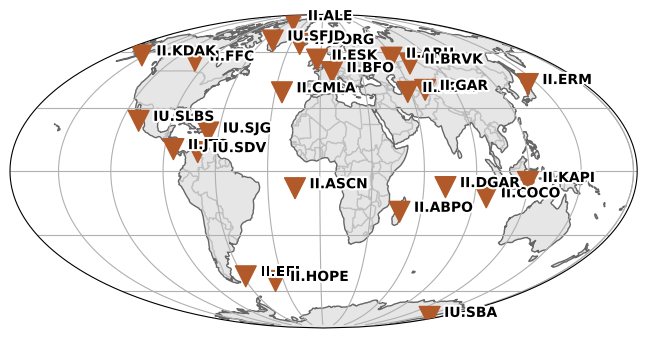

In [14]:
%matplotlib inline
# In this case I use the stations file from the EXAMPLE simulation to create an
# inventory object
inv = data.create_inventory(path_to_station_file='data/EXAMPLE/input/GSN_small.txt')
inv.plot()
plt.show()

The most valuable method, however, is the *stream* method, which interpolates any desired channel (if available) at any points (within the domain) and returns a stream object. 

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 639.57point/s]


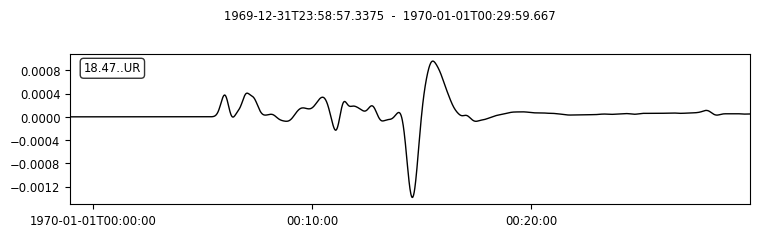

In [15]:
# Create a point of the form [radius, latitude, longitude]
point = np.array([6371000, 30, 0])
my_stream = data.stream(point, channels=['UR'])
my_stream.plot()
plt.show()

If you want to know which channels are available, you can check the metadata for the given element group (here we have only one element group: mantle)

In [16]:
data.element_groups_info['mantle']['metadata']['detailed_channels']

['UR', 'UT', 'UZ', 'ERR', 'ETT', 'EZZ', 'ETZ', 'EZR', 'ERT']

We can also interpolate at multiple points at once. It is importat however, that all the points have the desired channels (for example, a point in the outer core will not have any channels for strain, while points in the mantle will have).

Loading and interpolating: 100%|██████████| 3/3 [00:00<00:00, 557.80point/s]


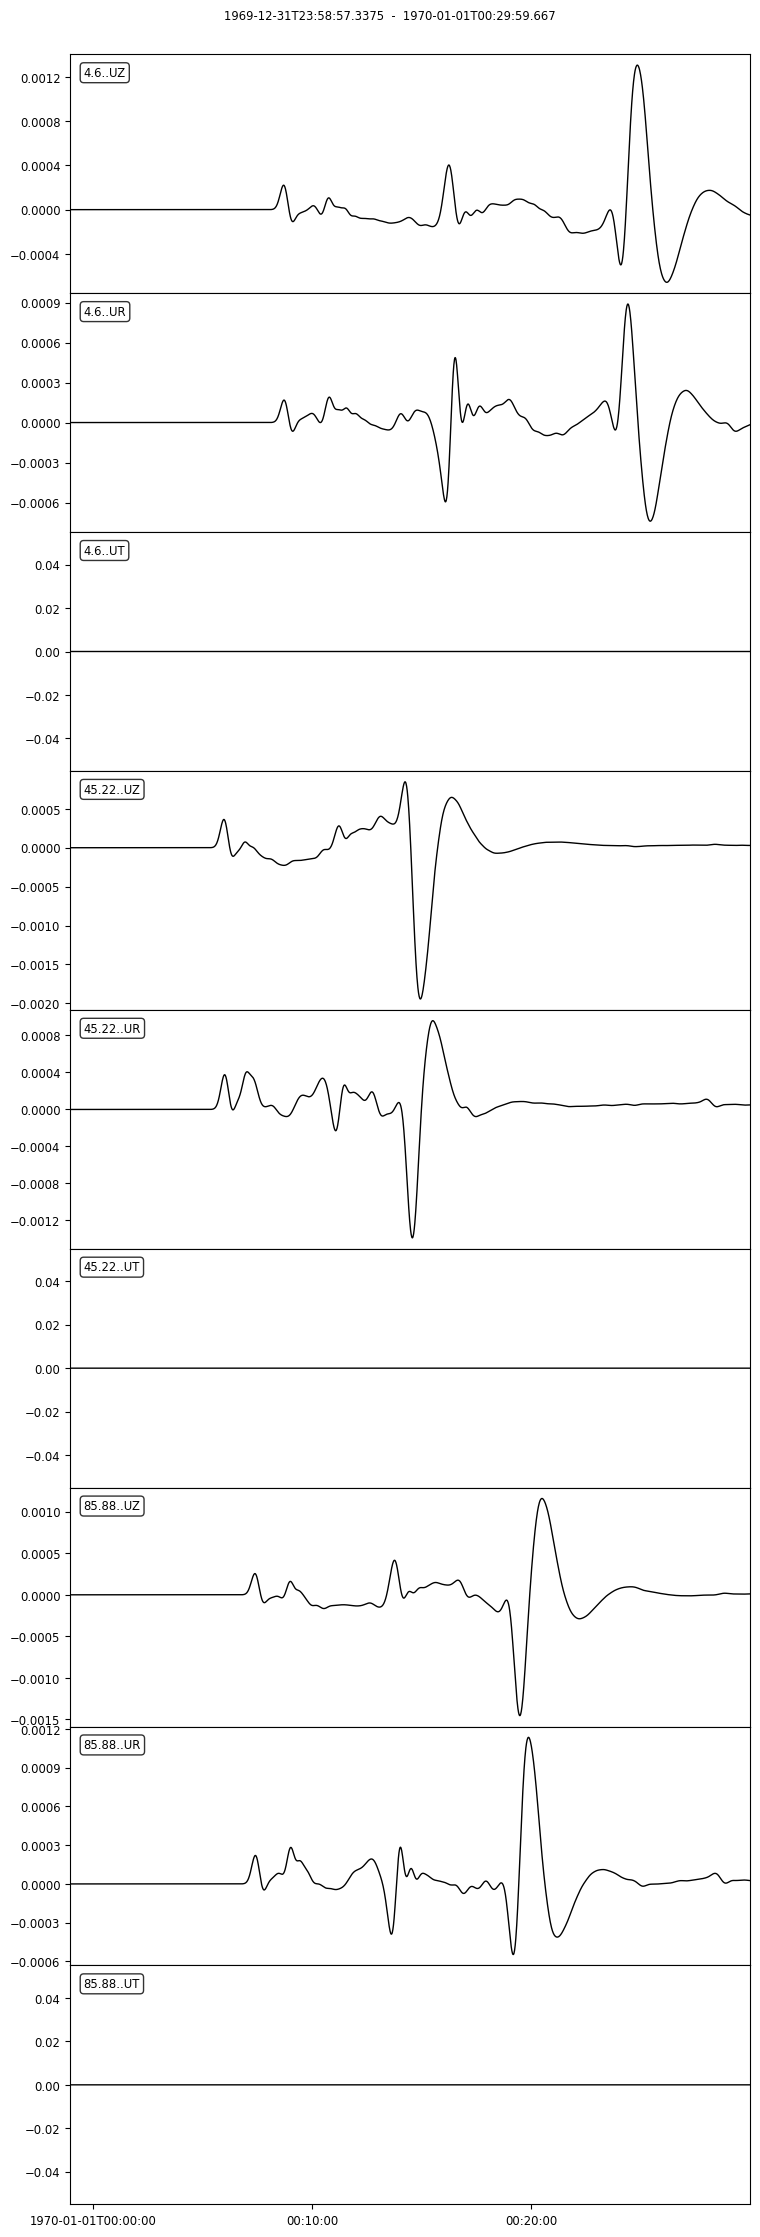

In [17]:
many_points = np.array([[6371000, 30, 0], [6371000, 40, 0], [6371000, 50, 0]])
other_stream = data.stream(many_points, channels=['UR', 'UT', 'UZ'])
other_stream.plot(equal_scale=False)
plt.show()

If we want to interpolate the wavefield at some stations defined in a station file, we can do so using the *.stream_STA()* method and passing the path to the station file. In this case we will use the station file from the EXAMPLE simulation.

Loading and interpolating: 100%|██████████| 25/25 [00:00<00:00, 685.60point/s]


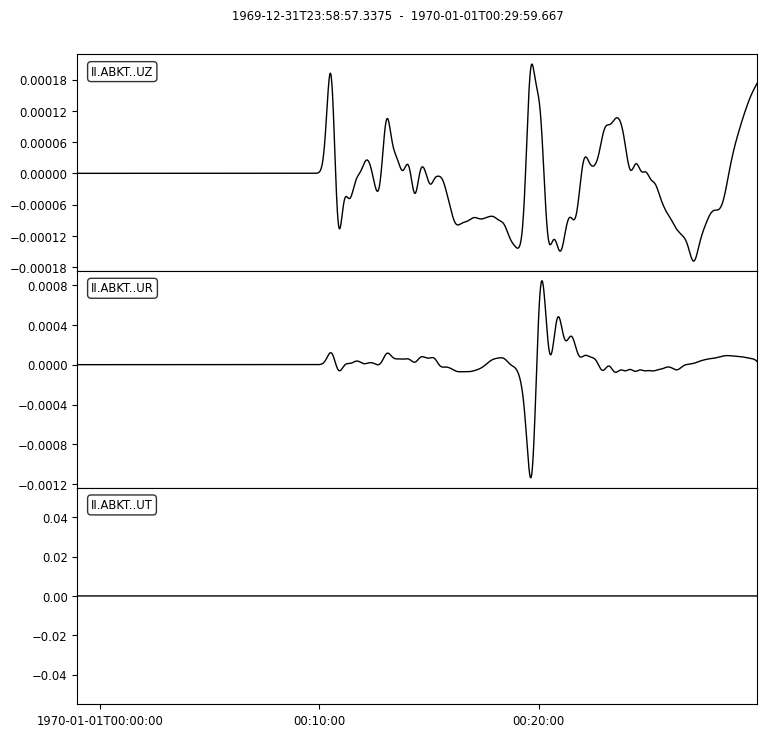

In [18]:
new_stream = data.stream_STA(path_to_station_file='data/EXAMPLE/input/GSN_small.txt', channels=['UR', 'UT', 'UZ'])
new_stream[0:3].plot(equal_scale=False)
plt.show()

Alternatively, we can pass the path to a station file to the *.obspyfy()* method, which will create and save a catalogue (based on this simulation's source), an inventory (based on the station file passed), and an mseed file (interpolated at the locations in the station file).

In [19]:
data.obspyfy(path_to_station_file='data/EXAMPLE/input/GSN_small.txt', channels=['UR', 'UT', 'UZ'])

Loading and interpolating: 100%|██████████| 25/25 [00:00<00:00, 739.23point/s]


Lastly, we can create simple animations from the raw wavefield. *.animation()* creates and animation on a great circle slice of the Earth. It can work without any args and it will return an animation through a slice containing the source. It can use args for resolution, which channels to plot, whether it is a log or linear plot, and on which domains to plot. A specific slice can be chosen by passing two "defining" points as args, which will uniquely determine the slice (for ex. source + some station). The plotting domain is specified by the minimum and maximum radii and the minimum and maximum azimuth from the first defining point.

In [20]:
""" data.animation(source_location=np.array([6371000, 0, 0]),
               station_location=np.array([6371000, 0, 30]),
               channels=['UZ'],
               resolution=500) """

" data.animation(source_location=np.array([6371000, 0, 0]),\n               station_location=np.array([6371000, 0, 30]),\n               channels=['UZ'],\n               resolution=500) "